In [1]:
from pathlib import Path
from src.model.ITrackerData import TrainITrackerData
from src.model.ITrackerData import TestITrackerData
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from src.model.ITrackerModel import ITrackerModel

In [2]:
dataset_file = Path("../data/raw/gazecapture_subset/eye_tracker_train_and_val.npz")

## Training

In [3]:
# Create datasets for training & validation, download if necessary
training_set = TrainITrackerData(str(dataset_file))
validation_set = TestITrackerData(str(dataset_file))

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 48000 instances
Validation set has 5000 instances


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


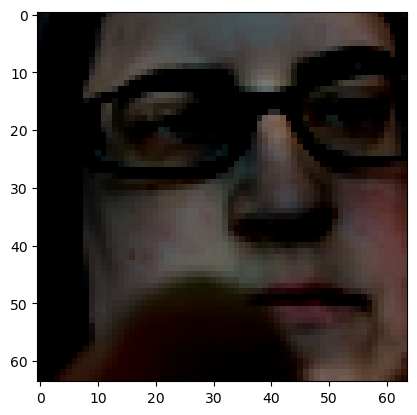

In [6]:
dataiter = iter(training_loader)
face, eye_left, eye_right, face_mask, y = next(dataiter)

# Create a grid from the images and show them
plt.imshow(np.transpose(face.numpy()[0], (1, 2, 0)))

In [7]:
face[0].numpy().shape
eye_left[0].numpy().shape

(3, 64, 64)

In [8]:
# Hyperparameters
lr = 1e-3
batch_size = 128
print_per_epoch = 10

model = ITrackerModel()
loss_fn = torch.nn.MSELoss
optimizer = torch.optim.Adam(model.parameters(), lr)

In [9]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        faces, eyes_left, eyes_right, face_masks, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(faces, eyes_left, eyes_right, face_masks)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            running_loss = 0.

    return last_loss

In [10]:
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    print(f"Epoch: {epoch_number + 1}")
    print(f"Train Loss: {avg_loss}")
    print(f"Val Loss: {avg_vloss}")

    epoch_number += 1

EPOCH 1:


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x512 and 18432x128)